In [2]:
import os
import torch
import torch.nn as tnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import splitfolders
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import albumentations as A
import kornia
import time
import datetime

from PIL import Image
from pydicom import dcmread
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [3]:
torch.cuda.empty_cache()

## Utils

In [4]:
%run gan_utils.ipynb

In [5]:
def write_to_tensorboard(writer, loss, metric, tensorboard_step):
    writer.add_scalar(metric, loss, global_step=tensorboard_step)

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
class EarlyStopping():
    """source: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, model, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = -np.inf
        self.model = model

    def early_stop(self, validation_loss):
        if validation_loss > (self.min_validation_loss + self.min_delta):
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(self.model.state_dict(), 'models/vgg16.pkl')
        elif validation_loss < self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Dataset and Loader

In [6]:
def normalize(image):
    min_val = MIN_HU_VALUE
    max_val = MAX_HU_VALUE
    image[image < min_val] = min_val
    image[image > max_val] = max_val
    image = (image - min_val) / (max_val - min_val)
    return image

class LungNoduleDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        images = os.listdir(image_dir)
        if 'rtss.dcm' in images: images.remove('rtss.dcm')
        self.images = images


    def __len__(self):
         return len(self.images)


    def __getitem__(self, index):
        hist_type_class = {'LUSC': 0 , 'LUAD': 1}
        img_path = os.path.join(self.image_dir, self.images[index])
        data = dcmread(img_path)
        image = np.array(data.pixel_array).astype('float32')
        # Conversio to HU
        intercept = int(data.RescaleIntercept)
        slope = int(data.RescaleSlope)
        image = (slope * image) + intercept
        image = normalize(image)
        
        label = img_path.split('/')[-1].split('_')[1]
        label = torch.from_numpy(np.asarray(hist_type_class[label]))
        
#         label = 1 if img_path.split('/')[-1].split('_')[0] == 'GAN' else 0
        
        return self.transform(image), label

In [7]:
def get_loaders(
    train_dir,
    val_dir,
    test_dir,
    train_transform,
    test_transform,
    n_samples=None
):
    train_dataset = LungNoduleDataset(image_dir=train_dir, transform=train_transform)
    val_dataset = LungNoduleDataset(image_dir=val_dir, transform=test_transform)
    test_dataset = LungNoduleDataset(image_dir=test_dir, transform=test_transform)
    
    # Samples n_samples data points from the training dataset
    if n_samples:
        len_dataset = len(train_dataset)
        indices = list(range(len_dataset))
        np.random.shuffle(indices)
        train_dataset = Subset(train_dataset, indices[:n_samples])
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    
    return train_loader, val_loader, test_loader

In [8]:
class SharpenImage():
    def __init__(self, kernel_size=(5,5), sigma=(2.5,2.5)):
        self.kernel_size = kernel_size
        self.sigma = sigma
    
    def __call__(self, x): 
        x = kornia.utils.image_to_tensor(x, keepdim=False)
        sharpen = kornia.filters.UnsharpMask(self.kernel_size, self.sigma)
        sharpened_tensor = sharpen(x)
        return sharpened_tensor[0][0].numpy()
    
class RandomRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

Train dataset size: 5439
Val dataset size: 679
Test dataset size: 681
Image Batch dimensions: torch.Size([32, 1, 64, 64])
Image Label dimensions: torch.Size([32])
Class labels of 5 examples: tensor([0, 1, 1, 1, 1])


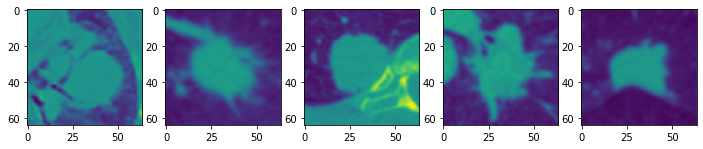

In [9]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
MIN_HU_VALUE = -1024
MAX_HU_VALUE = 1000
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5],
                         std  = [0.5]),
    ])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5],
                         std  = [0.5]),
    ])


#VGG16
"""
convolution + ReLU;
max pooling;
fully connected + ReLU;
softmax;

new dataset:
/Storage/PauloOctavioDir/NSCLC-Radiomics/ 

old dataset:
/Storage/PauloOctavioDir/Exames/
"""

# trainData = LungNoduleDataset(image_dir='/Storage/PauloOctavioDir/nodule_images/NSCLC/', transform=transform)
# testData = LungNoduleDataset(image_dir='/Storage/PauloOctavioDir/nodule_images/HCRP/', transform=transform)

train_dataset = LungNoduleDataset(image_dir='/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images', transform=train_transform)
val_dataset = LungNoduleDataset(image_dir='/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/val/images', transform=test_transform)
test_dataset = LungNoduleDataset(image_dir='/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/test/images', transform=test_transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

train_loader, val_loader, test_loader = get_loaders(
    train_dir = '/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images',
    val_dir = '/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/val/images',
    test_dir = '/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/test/images',
    train_transform = train_transform,
    test_transform = test_transform,
)

# Checking the dataset 
for images, labels in train_loader:
    print('Image Batch dimensions:', images.shape)
    print('Image Label dimensions:', labels.shape)
    print('Class labels of 5 examples:', labels[:5])
    fig, ax = plt.subplots(1,5, figsize=(12,6))
    for i, image in enumerate(images[:5]):
        ax[i].imshow(image[0], vmin=-1, vmax=1)
    plt.show()
    break

In [10]:
label_count = {'Squamous': 0 , 'Adenocarcinoma': 0}
for _, label in train_loader:
    label_count['Squamous'] += BATCH_SIZE - label.sum()
    label_count['Adenocarcinoma'] += label.sum()
total = sum(label_count.values())
{k: v / total for k, v in label_count.items()}

{'Squamous': tensor(0.5575), 'Adenocarcinoma': tensor(0.4425)}

In [11]:
def get_dataset_count():
    dataset_count = {'HCRP': 0, 'NSCLC': 0, 'LPET': 0, 'GAN': 0}
    for file in os.listdir('/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images'):
        dataset = file.split("_")[0]
        dataset_count[dataset] +=1
    return dataset_count
get_dataset_count()

{'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 0}

### Model

In [12]:
def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = tnn.Sequential(
        tnn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        tnn.BatchNorm2d(chann_out),
        tnn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [ tnn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return tnn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out):
    layer = tnn.Sequential(
        tnn.Linear(size_in, size_out),
        tnn.BatchNorm1d(size_out),
        tnn.ReLU(),
        tnn.Dropout(DROPOUT)
    )
    return layer

class VGG16(tnn.Module):
    def __init__(self, n_classes=1000):
        super(VGG16, self).__init__()

        # Conv blocks (BatchNorm + ReLU activation added in each block)
        self.layer1 = vgg_conv_block([1,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_block([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)
        self.layer5 = vgg_conv_block([512,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)

        # FC layers
        self.layer6 = vgg_fc_layer(2 * 2 * 512, 4096)
        self.layer7 = vgg_fc_layer(4096, 4096)

        # Final layer
        self.layer8 = tnn.Linear(4096, n_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        vgg16_features = self.layer5(out)
        out = vgg16_features.view(out.size(0), -1)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)

        return vgg16_features, out
    
    def predict(self, x):
        # a function to predict the labels of a batch of inputs
        x = tnn.functional.softmax(self.forward(x, training=False))
        return x

### Training

In [13]:
# Train the model
def train(train_loader, val_loader, overwritten_model_name=None, gan=None):
    
    # Model
    vgg16 = VGG16(n_classes=N_CLASSES)
    vgg16.cuda()
    
    # Loss, Optimizer & Scheduler
    cost = tnn.CrossEntropyLoss()
    if OPTIMIZER == 'SGD':
        optimizer = torch.optim.SGD(vgg16.parameters(), lr=LEARNING_RATE, weight_decay = 0.0005, momentum = 0.9) 
    if OPTIMIZER == 'Adam':
        optimizer = torch.optim.Adam(vgg16.parameters(), lr=LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    dataset_count = get_dataset_count()
    print(f"Dataset distribution: {dataset_count}")
    if overwritten_model_name:
        model_name = overwritten_model_name
    else:
        model_name = f"{TENSORBOARD_MODEL_NAME}_{dataset_count['GAN']}_{gan}_s_{SEED}"
    writer = SummaryWriter(f"logs/{model_name}")
    early_stopping = EarlyStopping(patience=15, min_delta=0.001, model=vgg16)
    print('Starting model training...')
    start = time.time()
    for epoch in range(EPOCH):
        avg_loss = 0
        cnt = 0
        batches = len(train_loader)
        # Training
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            _, outputs = vgg16(images)
            loss = cost(outputs, labels)
            avg_loss += loss.data
            cnt += 1
            if i % 500 == 0 and VERBOSE:
                print(f"[E: {epoch}] loss: {loss.data}, avg_loss: {avg_loss/cnt}")
            loss.backward()
            optimizer.step()
        write_to_tensorboard(writer, loss.data, "train/loss", tensorboard_step= epoch + 1)
        # Validation 
        with torch.no_grad():
            correct = 0
            samples = 0
            for _, (images, labels) in enumerate(val_loader):
                images = images.cuda()
                _, outputs = vgg16(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted.cpu() == labels).sum()
                samples += predicted.size(0)
                acc = correct / samples
            write_to_tensorboard(writer, acc, "val/acc", tensorboard_step= epoch + 1)
        if OPTIMIZER == 'Adam':
            scheduler.step(avg_loss / cnt)
        if early_stopping.early_stop(acc):
            break
    end = time.time()
    print('Finished model training!')
    training_duration = str(datetime.timedelta(seconds= end - start))
    print(f"Trainig duration: {training_duration}")
    return model_name

### Testing

In [14]:
# Test the model
def test(test_loader, model_name, gan_model):
    vgg16 = VGG16(n_classes=N_CLASSES)
    vgg16.cuda()
    vgg16.load_state_dict(torch.load('models/vgg16.pkl'))
    vgg16.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        incorrect_examples_images = []
        incorrect_examples_true_labels = []
        for i, (images, labels) in enumerate(test_loader):
            images = images.cuda()
            _, outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum()
            incorret_mask = predicted.cpu() != labels
            if len(images[incorret_mask]):
                for image in images[incorret_mask]:
                    incorrect_examples_images.append(image[0].cpu().numpy())
                for label in labels[incorret_mask]:
                    incorrect_examples_true_labels.append(label.cpu().numpy())
            if i == 0:
                preds = predicted.cpu().squeeze(-1).numpy()
                target = labels.cpu().squeeze(-1).numpy()
            else:
                preds = np.concatenate([preds, predicted.cpu().squeeze(-1).numpy()])
                target = np.concatenate([target, labels.cpu().squeeze(-1).numpy()])
    print(f'Finished model {model_name} evaluation!')
    cls_report_dict = classification_report(target, preds, digits=3, output_dict=True)
    df_log = pd.read_csv('vgg16_logging.csv')
    dataset_count = get_dataset_count()
    metrics = [
        model_name,
        dataset_count['GAN'],
        cls_report_dict['accuracy'],
#         roc_auc_score(target, preds),
        0,
        cls_report_dict['macro avg']['precision'],
        cls_report_dict['macro avg']['recall'],
        cls_report_dict['macro avg']['f1-score'],
        int(BATCH_SIZE),
        LEARNING_RATE,
        int(EPOCH),
        OPTIMIZER,
        DROPOUT,
        int(SEED),
        gan_model,
    ]
    df_log.loc[len(df_log)] = metrics
    df_log.to_csv('vgg16_logging.csv', index=False)
    print(f"Test acc: {cls_report_dict['accuracy']} | Test f1-score: {cls_report_dict['macro avg']['f1-score']}")
    print('Saved testing logs.')
    
def plot_ROCAUC_curve(y_truth, y_proba, fig_size):
    '''
    Plots the Receiver Operating Characteristic Curve (ROC) and displays Area Under the Curve (AUC) score.
    Args:
        y_truth: ground truth for testing data output
        y_proba: class probabilties predicted from model
        fig_size: size of the output pyplot figure
    Returns: void
    '''

    fpr, tpr, threshold = roc_curve(y_truth, y_proba)
    auc_score = roc_auc_score(y_truth, y_proba)
    txt_box = "AUC Score: " + str(round(auc_score, 4))
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'--')
    plt.annotate(txt_box, xy=(0.65, 0.05), xycoords='axes fraction')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.show()

### Hyperparameters

In [15]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCH = 75
N_CLASSES = 2
DEVICE = torch.device('cuda:1' if torch.cuda.is_available else 'cpu')
MIN_HU_VALUE = -1024
MAX_HU_VALUE = 1000
IMAGE_SIZE = 64
TENSORBOARD_MODEL_NAME = 'vgg16_gan'
VERBOSE = True
OPTIMIZER = 'SGD'
DROPOUT = .5
SEED = 13
TRAIN_DIR = '/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images'
VAL_DIR = '/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/val/images'
TEST_DIR = '/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/test/images'
NUM_WORKERS = 4

# TRAIN_DIR = '/Storage/PauloOctavioDir/splitted_folders/gan_vs_real_adeno/train/gan_vs_real_adeno'
# VAL_DIR = '/Storage/PauloOctavioDir/splitted_folders/gan_vs_real_adeno/val/gan_vs_real_adeno'
# TEST_DIR = '/Storage/PauloOctavioDir/splitted_folders/gan_vs_real_adeno/test/gan_vs_real_adeno'

In [16]:
# df_log = pd.DataFrame(
#     columns=['model_name', 'no_gan_generated_images','avg_acc', 'auc', 'avg_precision', 'avg_recall', 'avg_f1-score'])
# df_log.to_csv('vgg16_logging.csv', index=False)

In [17]:
# IMAGE_SIZE = 64
# images_probs = {}
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor(),
#     transforms.RandomRotation(degrees = 90),
#     transforms.RandomRotation(degrees = 180),
#     transforms.RandomRotation(degrees = 270),
#     transforms.GaussianBlur(3, sigma=3),
#     transforms.RandomAdjustSharpness(sharpness_factor, p=0.5),
#     transforms.Normalize(mean = [0.5],
#                          std  = [0.5]),
#     ])

# vgg16 = VGG16(n_classes=N_CLASSES)
# vgg16.cuda()
# vgg16.load_state_dict(torch.load('models/vgg16.pkl'))
# vgg16.eval()
# gan_dir = '/Storage/PauloOctavioDir/gan_eval/gan_vs_real_adeno'
# with torch.no_grad():
#     for img_path in os.listdir(gan_dir):
#         if img_path.startswith('GAN'):
#             data = dcmread(gan_dir + img_path)
#             image = np.array(data.pixel_array).astype('float32')
#             image = transform(image)
#             _, output = vgg16(image)
#             prob = tnn.functional.softmax(output)
#             images_probs[img_path] = prob[0]
            
# best_images = dict(sorted(images_probs.items(), key=lambda item: item[1]))

In [20]:
# Modelo Treinado apenas com iamgens reais

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5],
                         std  = [0.5]),
    ])
SEED = 42
seed_everything(SEED)
delete_gan_images()
train_loader, val_loader, test_loader = get_loaders(
    train_dir = TRAIN_DIR,
    val_dir = VAL_DIR,
    test_dir = TEST_DIR,
    train_transform = transform,
    test_transform = transform,
)
gan_model = 'no_gan'
overwritten_model_name = f"{TENSORBOARD_MODEL_NAME}_only_real_images_s_{SEED}"
model_name = train(train_loader, val_loader, overwritten_model_name=overwritten_model_name)
test(test_loader, model_name, gan_model=gan_model)

Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 0}
Starting model training...
[E: 0] loss: 0.86026531457901, avg_loss: 0.86026531457901
[E: 1] loss: 0.6894057989120483, avg_loss: 0.6894057989120483
[E: 2] loss: 1.0190683603286743, avg_loss: 1.0190683603286743
[E: 3] loss: 1.2963334321975708, avg_loss: 1.2963334321975708
[E: 4] loss: 0.3178514540195465, avg_loss: 0.3178514540195465
[E: 5] loss: 0.2536715567111969, avg_loss: 0.2536715567111969
[E: 6] loss: 0.2151365727186203, avg_loss: 0.2151365727186203
[E: 7] loss: 0.1340058445930481, avg_loss: 0.1340058445930481
[E: 8] loss: 0.26030847430229187, avg_loss: 0.26030847430229187
[E: 9] loss: 0.06734580546617508, avg_loss: 0.06734580546617508
[E: 10] loss: 0.14740264415740967, avg_loss: 0.14740264415740967
[E: 11] loss: 0.02768835984170437, avg_loss: 0.02768835984170437
[E: 12] loss: 0.08520285785198212, avg_loss: 0.08520285785198212
[E: 13] loss: 0.019149357452988625, avg_loss: 0.019149357452988625
[E: 14] loss: 0.

In [18]:
# Validação do modelo treinado apenas com imagens reais usando apenas imagens da GAN

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5],
                         std  = [0.5]),
    ])
SEED = 42
no_gan_images = 1400

scc_list = [
    f'generator_pggan_roi_squamous_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar',
    f'generator_pggan_roi_squamous_all_data.pth.tar', 
    f'generator_pggan_roi_squamous_epochs_75_lr_0.001.pth.tar',
    f'generator_pggan_roi_squamous_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
    f'generator_pggan_roi_squamous_epochs_30_30_50_50_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar'
]

adc_list = [
    f'generator_pggan_roi_adeno_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar',
    f'generator_pggan_roi_adeno_all_data.pth.tar', 
    f'generator_pggan_roi_adeno_epochs_75_lr_0.001.pth.tar',
    f'generator_pggan_roi_adeno_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
    f'generator_pggan_roi_adeno_epochs_30_30_50_50_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar'
]
# hist_type = 'adeno'
# adc_list = [
#     f'generator_pggan_roi_{hist_type}_epochs_30_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar',
#     f'generator_pggan_roi_{hist_type}_epochs_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar',
#     f'generator_pggan_roi_{hist_type}_epochs_50_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar',
#     f'generator_pggan_roi_{hist_type}_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#     f'generator_pggan_roi_{hist_type}_epochs_30_30_50_50_50_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#     f'generator_pggan_roi_{hist_type}_epochs_30_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#     f'generator_pggan_roi_{hist_type}_epochs_50_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#     f'generator_pggan_roi_{hist_type}_epochs_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#     f'generator_pggan_roi_{hist_type}_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar',
#     f'generator_pggan_roi_{hist_type}_all_data.pth.tar', 
#     f'generator_pggan_roi_{hist_type}_epochs_75_lr_0.001.pth.tar',
# ]


for gen_adeno, gen_squamous in zip(adc_list, scc_list):
# for gen_adeno in adc_list:
    directory = '/Storage/PauloOctavioDir/gan_eval/vgg16_real_imgs/'
    for file in os.listdir(directory):
            os.remove(os.path.join(directory, file))
    generate_images(
        gen_squamous, no_gan_images // 2, 'LUSC', "/Storage/PauloOctavioDir/gan_eval/vgg16_real_imgs")
    generate_images(
        gen_adeno, no_gan_images // 2, 'LUAD', "/Storage/PauloOctavioDir/gan_eval/vgg16_real_imgs")
    train_loader, val_loader, test_loader = get_loaders(
        train_dir = TRAIN_DIR,
        val_dir = VAL_DIR,
        test_dir = '/Storage/PauloOctavioDir/gan_eval/vgg16_real_imgs',
        train_transform = transform,
        test_transform = transform,
    )
    print(f'Model: {gen_adeno}')
    gan_model = gen_adeno
    model_name = f'test_vgg16_trained_on_real_imgs_classifying_gan_imgs_s_{SEED}'
    test(test_loader, model_name, gan_model=gan_model)

=> Loading checkpoint
=> Loading checkpoint
Model: generator_pggan_roi_adeno_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar
Finished model test_vgg16_trained_on_real_imgs_classifying_gan_imgs_s_42 evaluation!
Test acc: 0.6213662790697675 | Test f1-score: 0.619232756894507
Saved testing logs.
=> Loading checkpoint
=> Loading checkpoint
Model: generator_pggan_roi_adeno_all_data.pth.tar
Finished model test_vgg16_trained_on_real_imgs_classifying_gan_imgs_s_42 evaluation!
Test acc: 0.7122093023255814 | Test f1-score: 0.7119896486765909
Saved testing logs.
=> Loading checkpoint
=> Loading checkpoint
Model: generator_pggan_roi_adeno_epochs_75_lr_0.001.pth.tar
Finished model test_vgg16_trained_on_real_imgs_classifying_gan_imgs_s_42 evaluation!
Test acc: 0.6257267441860465 | Test f1-score: 0.6256221448431913
Saved testing logs.
=> Loading checkpoint
=> Loading checkpoint
Model: generator_pggan_roi_adeno_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar
Finished model te

FileNotFoundError: [Errno 2] No such file or directory: 'generator_pggan_roi_adeno_epochs_30_30_50_50_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar'

In [43]:
aug_transform = transforms.Compose([
#     transforms.RandomApply([SharpenImage()], p=.3),
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=.2),
#     transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(1,2))], p=.3),
    RandomRotationTransform(angles=[90,270, 0, 0, 0, 0, 0, 0, 0, 0]),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5],
                         std  = [0.5]),
])

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5],
                         std  = [0.5]),
    ])

gen_adeno = "generator_pggan_roi_adeno_all_data.pth.tar"
gen_squamous = "generator_pggan_roi_squamous_all_data.pth.tar"
for SEED in [42]:
    for no_gan_images in [0, 1000, 2000, 3000, 4000, 5000]:
        seed_everything(SEED)
        print(f"{no_gan_images} GAN images:")
        delete_gan_images()
        generate_images(
            gen_squamous, no_gan_images // 2, 'LUSC', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        generate_images(
            gen_adeno, no_gan_images // 2, 'LUAD', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        train_loader, val_loader, test_loader = get_loaders(
            train_dir = TRAIN_DIR,
            val_dir = VAL_DIR,
            test_dir = TEST_DIR,
            train_transform = aug_transform,
            test_transform = transform,
        )
        gan_model = 'old_gan'
        overwritten_model_name = f"{TENSORBOARD_MODEL_NAME}_augmented_rot_.2_flip_.2_{no_gan_images}_{gan_model}_s_{SEED}"
        model_name = train(train_loader, val_loader, overwritten_model_name=overwritten_model_name)
        test(test_loader, model_name, gan_model=gan_model)

0 GAN images:
=> Loading checkpoint
=> Loading checkpoint
Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 0}
Starting model training...
[E: 0] loss: 0.9058138132095337, avg_loss: 0.9058138132095337
[E: 1] loss: 0.6920968890190125, avg_loss: 0.6920968890190125
[E: 2] loss: 0.8057072162628174, avg_loss: 0.8057072162628174
[E: 3] loss: 1.611696481704712, avg_loss: 1.611696481704712
[E: 4] loss: 1.3430839776992798, avg_loss: 1.3430839776992798
[E: 5] loss: 0.837726354598999, avg_loss: 0.837726354598999
[E: 6] loss: 0.492527037858963, avg_loss: 0.492527037858963
[E: 7] loss: 0.9208222031593323, avg_loss: 0.9208222031593323
[E: 8] loss: 0.5225419402122498, avg_loss: 0.5225419402122498
[E: 9] loss: 0.723551332950592, avg_loss: 0.723551332950592
[E: 10] loss: 0.7505784630775452, avg_loss: 0.7505784630775452
[E: 11] loss: 0.5143197774887085, avg_loss: 0.5143197774887085
[E: 12] loss: 0.3873656690120697, avg_loss: 0.3873656690120697
[E: 13] loss: 1.4416784048080444, avg_l

[E: 53] loss: 0.19626326858997345, avg_loss: 0.19626326858997345
Finished model training!
Trainig duration: 0:41:41.545223
Finished model vgg16_gan_augmented_rot_.2_flip_.2_1000_old_gan_s_42 evaluation!
Test acc: 0.8928571428571429
Saved testing logs.
2000 GAN images:
=> Loading checkpoint
=> Loading checkpoint
Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 2000}
Starting model training...
[E: 0] loss: 0.8612524271011353, avg_loss: 0.8612524271011353
[E: 1] loss: 0.7224250435829163, avg_loss: 0.7224250435829163
[E: 2] loss: 0.7187500596046448, avg_loss: 0.7187500596046448
[E: 3] loss: 0.913865864276886, avg_loss: 0.913865864276886
[E: 4] loss: 0.4695960283279419, avg_loss: 0.4695960283279419
[E: 5] loss: 1.0054901838302612, avg_loss: 1.0054901838302612
[E: 6] loss: 0.8005192875862122, avg_loss: 0.8005192875862122
[E: 7] loss: 0.6370477676391602, avg_loss: 0.6370477676391602
[E: 8] loss: 1.0177712440490723, avg_loss: 1.0177712440490723
[E: 9] loss: 0.80233192443

=> Loading checkpoint
=> Loading checkpoint
Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 4000}
Starting model training...
[E: 0] loss: 0.7297548055648804, avg_loss: 0.7297548055648804
[E: 1] loss: 0.6682664155960083, avg_loss: 0.6682664155960083
[E: 2] loss: 0.445983350276947, avg_loss: 0.445983350276947
[E: 3] loss: 0.4087845981121063, avg_loss: 0.4087845981121063
[E: 4] loss: 0.516315758228302, avg_loss: 0.516315758228302
[E: 5] loss: 0.4454565942287445, avg_loss: 0.4454565942287445
[E: 6] loss: 0.1903967261314392, avg_loss: 0.1903967261314392
[E: 7] loss: 0.5186139345169067, avg_loss: 0.5186139345169067
[E: 8] loss: 0.19738702476024628, avg_loss: 0.19738702476024628
[E: 9] loss: 0.1825411319732666, avg_loss: 0.1825411319732666
[E: 10] loss: 0.22915643453598022, avg_loss: 0.22915643453598022
[E: 11] loss: 0.08745978772640228, avg_loss: 0.08745978772640228
[E: 12] loss: 0.17052975296974182, avg_loss: 0.17052975296974182
[E: 13] loss: 0.1438826322555542, avg_

In [44]:
aug_transform = transforms.Compose([
    transforms.RandomApply([SharpenImage()], p=.2),
    transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(p=.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(1,2))], p=.2),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     RandomRotationTransform(angles=[90,270, 0, 0, 0, 0, 0, 0, 0, 0]),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5],
                         std  = [0.5]),
])

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5],
                         std  = [0.5]),
    ])

gen_adeno = "generator_pggan_roi_adeno_all_data.pth.tar"
gen_squamous = "generator_pggan_roi_squamous_all_data.pth.tar"
for SEED in [42]:
    for no_gan_images in [0, 1000, 2000, 3000, 4000, 5000]:
        seed_everything(SEED)
        print(f"{no_gan_images} GAN images:")
        delete_gan_images()
        generate_images(
            gen_squamous, no_gan_images // 2, 'LUSC', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        generate_images(
            gen_adeno, no_gan_images // 2, 'LUAD', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        train_loader, val_loader, test_loader = get_loaders(
            train_dir = TRAIN_DIR,
            val_dir = VAL_DIR,
            test_dir = TEST_DIR,
            train_transform = aug_transform,
            test_transform = transform,
        )
        gan_model = 'old_gan'
        overwritten_model_name = f"{TENSORBOARD_MODEL_NAME}_augmented_sharp_blur_{no_gan_images}_{gan_model}_s_{SEED}"
        model_name = train(train_loader, val_loader, overwritten_model_name=overwritten_model_name)
        test(test_loader, model_name, gan_model=gan_model)

0 GAN images:
=> Loading checkpoint
=> Loading checkpoint
Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 0}
Starting model training...
[E: 0] loss: 0.7926419973373413, avg_loss: 0.7926419973373413
[E: 1] loss: 0.6666727662086487, avg_loss: 0.6666727662086487
[E: 2] loss: 0.7884994745254517, avg_loss: 0.7884994745254517
[E: 3] loss: 1.0589654445648193, avg_loss: 1.0589654445648193
[E: 4] loss: 0.5936004519462585, avg_loss: 0.5936004519462585
[E: 5] loss: 0.36558207869529724, avg_loss: 0.36558207869529724
[E: 6] loss: 0.9656534194946289, avg_loss: 0.9656534194946289
[E: 7] loss: 0.2394169569015503, avg_loss: 0.2394169569015503
[E: 8] loss: 0.1767488420009613, avg_loss: 0.1767488420009613
[E: 9] loss: 0.3446007966995239, avg_loss: 0.3446007966995239
[E: 10] loss: 0.05813752859830856, avg_loss: 0.05813752859830856
[E: 11] loss: 0.09075944125652313, avg_loss: 0.09075944125652313
[E: 12] loss: 0.026701096445322037, avg_loss: 0.026701096445322037
[E: 13] loss: 0.00439

Finished model vgg16_gan_augmented_sharp_blur_1000_old_gan_s_42 evaluation!
Test acc: 0.9107142857142857
Saved testing logs.
2000 GAN images:
=> Loading checkpoint
=> Loading checkpoint
Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 2000}
Starting model training...
[E: 0] loss: 0.8582926988601685, avg_loss: 0.8582926988601685
[E: 1] loss: 0.8964390754699707, avg_loss: 0.8964390754699707
[E: 2] loss: 1.0839194059371948, avg_loss: 1.0839194059371948
[E: 3] loss: 0.39971259236335754, avg_loss: 0.39971259236335754
[E: 4] loss: 0.39023563265800476, avg_loss: 0.39023563265800476
[E: 5] loss: 0.21277333796024323, avg_loss: 0.21277333796024323
[E: 6] loss: 0.391241192817688, avg_loss: 0.391241192817688
[E: 7] loss: 0.1930381953716278, avg_loss: 0.1930381953716278
[E: 8] loss: 0.10241967439651489, avg_loss: 0.10241967439651489
[E: 9] loss: 0.19426938891410828, avg_loss: 0.19426938891410828
[E: 10] loss: 0.11032810807228088, avg_loss: 0.11032810807228088
[E: 11] loss: 0.

=> Loading checkpoint
=> Loading checkpoint
Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 5000}
Starting model training...
[E: 0] loss: 0.7514078617095947, avg_loss: 0.7514078617095947
[E: 1] loss: 0.4970112442970276, avg_loss: 0.4970112442970276
[E: 2] loss: 0.18590913712978363, avg_loss: 0.18590913712978363
[E: 3] loss: 0.2997806966304779, avg_loss: 0.2997806966304779
[E: 4] loss: 0.13439685106277466, avg_loss: 0.13439685106277466
[E: 5] loss: 0.2912866473197937, avg_loss: 0.2912866473197937
[E: 6] loss: 0.05592681095004082, avg_loss: 0.05592681095004082
[E: 7] loss: 0.20297390222549438, avg_loss: 0.20297390222549438
[E: 8] loss: 0.01377089787274599, avg_loss: 0.01377089787274599
[E: 9] loss: 0.05768613889813423, avg_loss: 0.05768613889813423
[E: 10] loss: 0.1087113469839096, avg_loss: 0.1087113469839096
[E: 11] loss: 0.057024020701646805, avg_loss: 0.057024020701646805
[E: 12] loss: 0.006295282859355211, avg_loss: 0.006295282859355211
[E: 13] loss: 0.006484

In [ ]:
gen_adeno = "generator_pggan_roi_adeno_all_data.pth.tar"
gen_squamous = "generator_pggan_roi_squamous_all_data.pth.tar"
for SEED in [42]:
    for no_gan_images in [0, 1000, 2000, 3000, 4000, 5000]:
        seed_everything(SEED)
        print(f"{no_gan_images} GAN images:")
        delete_gan_images()
        generate_images(
            gen_squamous, no_gan_images // 2, 'LUSC', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        generate_images(
            gen_adeno, no_gan_images // 2, 'LUAD', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        train_loader, val_loader, test_loader = get_loaders(
            train_dir = TRAIN_DIR,
            val_dir = VAL_DIR,
            test_dir = TEST_DIR,
            transform = transform,
        )
        gan_model = 'old_gan'
        model_name = train(train_loader, val_loader, gan=gan_model)
        test(test_loader, model_name, gan_model=gan_model)

In [17]:
gen_adeno = "generator_pggan_roi_adeno_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar"
gen_squamous = "generator_pggan_roi_squamous_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar"
for SEED in [42]:
    for no_gan_images in [0, 1000, 2000, 3000, 4000, 5000]:
        seed_everything(SEED)
        print(f"{no_gan_images} GAN images:")
        delete_gan_images()
        generate_images(
            gen_squamous, no_gan_images // 2, 'LUSC', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        generate_images(
            gen_adeno, no_gan_images // 2, 'LUAD', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        train_loader, val_loader, test_loader = get_loaders(
            train_dir = TRAIN_DIR,
            val_dir = VAL_DIR,
            test_dir = TEST_DIR,
            transform = transform,
        )
        gan_model = 'gan_augmented_rot_blur_sharp'
        model_name = train(train_loader, val_loader, gan=gan_model)
        test(test_loader, model_name, gan_model=gan_model)

0 GAN images:
=> Loading checkpoint
=> Loading checkpoint
Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 0}
Starting model training...
[E: 0] loss: 0.8512869477272034, avg_loss: 0.8512869477272034
[E: 1] loss: 0.6348040103912354, avg_loss: 0.6348040103912354
[E: 2] loss: 0.6898595094680786, avg_loss: 0.6898595094680786
[E: 3] loss: 0.7726166844367981, avg_loss: 0.7726166844367981
[E: 4] loss: 1.0005995035171509, avg_loss: 1.0005995035171509
[E: 5] loss: 0.7265245318412781, avg_loss: 0.7265245318412781
[E: 6] loss: 0.6235077977180481, avg_loss: 0.6235077977180481
[E: 7] loss: 0.2916323244571686, avg_loss: 0.2916323244571686
[E: 8] loss: 0.47286587953567505, avg_loss: 0.47286587953567505
[E: 9] loss: 0.07735337316989899, avg_loss: 0.07735337316989899
[E: 10] loss: 0.01513221301138401, avg_loss: 0.01513221301138401
[E: 11] loss: 0.029895029962062836, avg_loss: 0.029895029962062836
[E: 12] loss: 0.03139519691467285, avg_loss: 0.03139519691467285
[E: 13] loss: 0.044

[E: 1] loss: 0.8088873624801636, avg_loss: 0.8088873624801636
[E: 2] loss: 0.5457770824432373, avg_loss: 0.5457770824432373
[E: 3] loss: 0.8673291206359863, avg_loss: 0.8673291206359863
[E: 4] loss: 0.4374731779098511, avg_loss: 0.4374731779098511
[E: 5] loss: 0.2874881327152252, avg_loss: 0.2874881327152252
[E: 6] loss: 0.15612030029296875, avg_loss: 0.15612030029296875
[E: 7] loss: 0.26222261786460876, avg_loss: 0.26222261786460876
[E: 8] loss: 0.09325763583183289, avg_loss: 0.09325763583183289
[E: 9] loss: 0.09389194846153259, avg_loss: 0.09389194846153259
[E: 10] loss: 0.02456684783101082, avg_loss: 0.02456684783101082
[E: 11] loss: 0.09063897281885147, avg_loss: 0.09063897281885147
[E: 12] loss: 0.0299706868827343, avg_loss: 0.0299706868827343
[E: 13] loss: 0.028576567769050598, avg_loss: 0.028576567769050598
[E: 14] loss: 0.2878071665763855, avg_loss: 0.2878071665763855
[E: 15] loss: 0.04011151194572449, avg_loss: 0.04011151194572449
[E: 16] loss: 0.003602058393880725, avg_loss: 

[E: 10] loss: 0.004341069143265486, avg_loss: 0.004341069143265486
[E: 11] loss: 0.029069649055600166, avg_loss: 0.029069649055600166
[E: 12] loss: 0.01683320850133896, avg_loss: 0.01683320850133896
[E: 13] loss: 0.008926003240048885, avg_loss: 0.008926003240048885
[E: 14] loss: 0.010788977146148682, avg_loss: 0.010788977146148682
[E: 15] loss: 0.02988056093454361, avg_loss: 0.02988056093454361
[E: 16] loss: 0.0050187138840556145, avg_loss: 0.0050187138840556145
[E: 17] loss: 0.1706395000219345, avg_loss: 0.1706395000219345
[E: 18] loss: 0.004850083962082863, avg_loss: 0.004850083962082863
[E: 19] loss: 0.01684359833598137, avg_loss: 0.01684359833598137
[E: 20] loss: 0.02656053565442562, avg_loss: 0.02656053565442562
[E: 21] loss: 0.0008452652837149799, avg_loss: 0.0008452652837149799
[E: 22] loss: 0.01608157716691494, avg_loss: 0.01608157716691494
[E: 23] loss: 0.0016689600888639688, avg_loss: 0.0016689600888639688
[E: 24] loss: 0.001165078254416585, avg_loss: 0.001165078254416585
[E:

In [16]:
gen_adeno = "generator_pggan_roi_adeno_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar"
gen_squamous = "generator_pggan_roi_squamous_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar"
for no_gan_images in [3750]:
    for SEED in [42,13, 25, 89]:
        seed_everything(SEED)
        print(f"{no_gan_images} GAN images:")
        delete_gan_images()
        generate_images(
            gen_squamous, no_gan_images // 2, 'LUSC', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        generate_images(
            gen_adeno, no_gan_images // 2, 'LUAD', "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/")
        train_loader, val_loader, test_loader = get_loaders(
            train_dir = TRAIN_DIR,
            val_dir = VAL_DIR,
            test_dir = TEST_DIR,
            transform = transform,
        )
        gan_model = 'gan_augmented_rot_blur_sharp'
        model_name = train(train_loader, val_loader, gan=gan_model)
        test(test_loader, model_name, gan_model=gan_model)

3750 GAN images:
=> Loading checkpoint
=> Loading checkpoint
Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 3750}
Starting model training...
[E: 0] loss: 0.7698305249214172, avg_loss: 0.7698305249214172
[E: 1] loss: 0.6860306859016418, avg_loss: 0.6860306859016418
[E: 2] loss: 0.48612695932388306, avg_loss: 0.48612695932388306
[E: 3] loss: 0.24988311529159546, avg_loss: 0.24988311529159546
[E: 4] loss: 0.32356539368629456, avg_loss: 0.32356539368629456
[E: 5] loss: 0.07273389399051666, avg_loss: 0.07273389399051666
[E: 6] loss: 0.10050757974386215, avg_loss: 0.10050757974386215
[E: 7] loss: 0.024713989347219467, avg_loss: 0.024713989347219467
[E: 8] loss: 0.04186415672302246, avg_loss: 0.04186415672302246
[E: 9] loss: 0.20877602696418762, avg_loss: 0.20877602696418762
[E: 10] loss: 0.012968921102583408, avg_loss: 0.012968921102583408
[E: 11] loss: 0.04311098903417587, avg_loss: 0.04311098903417587
[E: 12] loss: 0.04963165894150734, avg_loss: 0.04963165894150734

[E: 57] loss: 0.00031611204030923545, avg_loss: 0.00031611204030923545
[E: 58] loss: 5.1863506087101996e-05, avg_loss: 5.1863506087101996e-05
[E: 59] loss: 9.729502198752016e-05, avg_loss: 9.729502198752016e-05
[E: 60] loss: 0.0009298360091634095, avg_loss: 0.0009298360091634095
[E: 61] loss: 0.0002956134849227965, avg_loss: 0.0002956134849227965
Finished model vgg16_gan_3750_gan_augmented_rot_blur_sharp_s_13 evaluation!
Test acc: 0.9241071428571429
Saved testing logs.
3750 GAN images:
=> Loading checkpoint
=> Loading checkpoint
Dataset distribution: {'HCRP': 1868, 'NSCLC': 2812, 'LPET': 759, 'GAN': 3750}
Starting model training...
[E: 0] loss: 0.7654435634613037, avg_loss: 0.7654435634613037
[E: 1] loss: 1.3010098934173584, avg_loss: 1.3010098934173584
[E: 2] loss: 0.677422285079956, avg_loss: 0.677422285079956
[E: 5] loss: 0.26478883624076843, avg_loss: 0.26478883624076843
[E: 6] loss: 0.32362455129623413, avg_loss: 0.32362455129623413
[E: 7] loss: 0.036340054124593735, avg_loss: 0.0

In [16]:
df_log = pd.read_csv('vgg16_logging.csv')
df_log

,model_name,no_gan_generated_images,avg_acc,auc,avg_precision,avg_recall,avg_f1-score,batch_size,learning_rate,epoch,optimizer,dropout,seed,gan_model
0,vgg16_gan_0_dropout_0.2_opt_Adam,0,0.895833,0.900178,0.888464,0.900178,0.892634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,vgg16_gan_0_dropout_0.2_opt_SGD,0,0.916667,0.913324,0.912237,0.913324,0.912772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,vgg16_gan_0_dropout_0.5_opt_SGD,0,0.922619,0.923574,0.916536,0.923574,0.919611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,vgg16_gan_2500_dropout_0.5_opt_SGD,2500,0.927083,0.927919,0.921259,0.927919,0.924203,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,vgg16_gan_5000_dropout_0.5_opt_SGD,5000,0.898810,0.903966,0.891534,0.903966,0.895811,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,vgg16_gan_0_dropout_0.5_opt_SGD,0,0.903274,0.904969,0.896232,0.904969,0.899807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,vgg16_gan_0_dropout_0.5_opt_SGD,0,0.909226,0.908534,0.903059,0.908534,0.905526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,vgg16_gan_2500_dropout_0.5_opt_SGD_old_gan,2500,0.907738,0.905971,0.901912,0.905971,0.903798,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,vgg16_gan_underfitting_test_1000_images,0,0.758929,0.765374,0.753917,0.765374,0.754526,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,vgg16_gan_underfitting_test_2000_images,0,0.828869,0.824978,0.819920,0.824978,0.822109,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
hist_type_class = {0:'squamous' , 1:'adeno'}
titles = []
for true_label in incorrect_examples_true_labels:
    pred_label = int(not true_label.item())
    true_class = hist_type_class[true_label.item()]
    pred_class = hist_type_class[pred_label]
    titles.append(f"pred: {pred_class} | label: {true_class}")
    
# show_image_list(incorrect_examples_images, titles, num_cols=5, figsize=(16, 32), title_fontsize=12)

In [ ]:
num_cols = 5
list_images = incorrect_examples_images
list_titles = titles
figsize = (14, 30)

num_images  = len(list_images)
num_cols    = min(num_images, num_cols)
num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
list_axes = list(axes.flat)
for i in range(num_images):
    img    = list_images[i]
    title  = list_titles[i] if list_titles is not None else None

    list_axes[i].imshow(img, cmap=None, vmin=-1, vmax=1)
    list_axes[i].set_title(title, fontsize=12) 

    fig.tight_layout()
plt.show()